In [3]:
%matplotlib inline

import pickle
import numpy as np
import pandas as pd
from plotnine import *

from retention import get_split_dfs

In [4]:
class theme_fs(theme_light):
    """
    A theme similar to :class:`theme_linedraw` but with light grey
    lines and axes to direct more attention towards the data.
    Parameters
    ----------
    base_size : int, optional
        Base font size. All text sizes are a scaled versions of
        the base font size. Default is 11.
    base_family : str, optional
        Base font family.
    """

    def __init__(self, base_size=11, base_family='DejaVu Sans'):
        theme_light.__init__(self, base_size, base_family)
        self.add_theme(theme(
            axis_ticks=element_line(color='#DDDDDD', size=0.5),
            panel_border=element_rect(fill='None', color='#838383',
                                      size=1),
            strip_background=element_rect(
                fill='#DDDDDD', color='#838383', size=1),
            strip_text_x=element_text(color='black'),
            strip_text_y=element_text(color='black', angle=-90),
            legend_key=element_blank(),
        ), inplace=True)

In [79]:
train_df, test_df = get_split_dfs()
with open('checkpoints/predictions.pkl', 'rb') as f:
    predictions = pickle.load(f)
test_df['pp'] = np.array(predictions)
results = test_df

loading train test df


/fs/clip-quiz/shifeng/anaconda/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 2 rows containing missing values.
  data = self.position.setup_data(self.data, params)


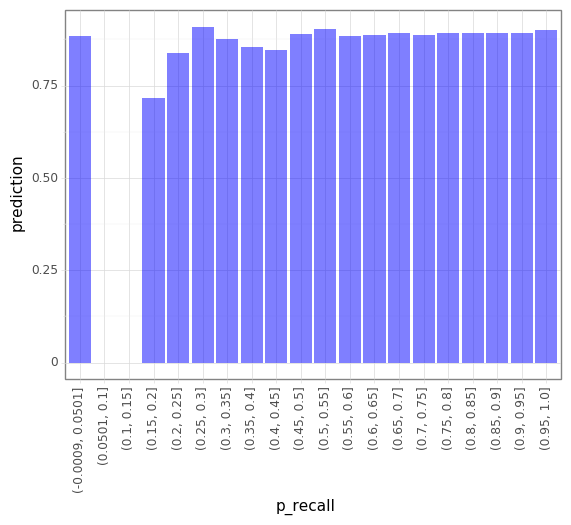

<ggplot: (8775339421673)>

In [80]:
def _bin_prediction(group):
    return pd.DataFrame([{'prediction':  group.pp.mean()}])

(
    ggplot(
        results.groupby(
            pd.cut(results.p_recall, 20)
        ).apply(_bin_prediction).reset_index()
    )
    + geom_bar(
        aes(x='p_recall', y='prediction'),
        stat='identity',
        fill='blue',
        alpha=0.5
    )
    + theme_fs()
    + theme(
        axis_text_x=element_text(rotation=90)
    )
)

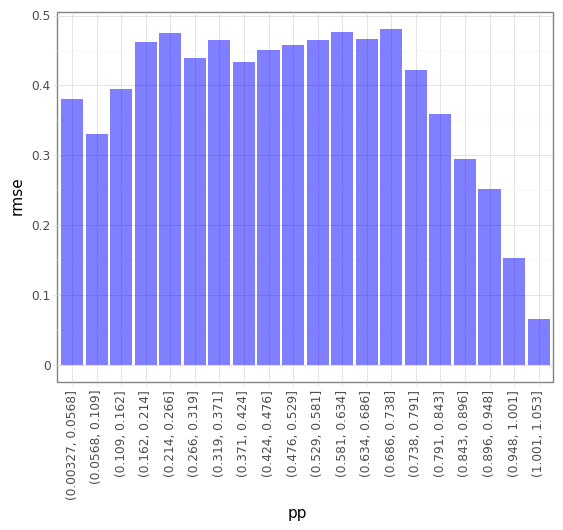

<ggplot: (8775190948141)>

In [81]:
def _bin_rmse(group):
    return pd.DataFrame([{
        'rmse':  ((group.pp - group.p_recall) ** 2).mean() ** (1/2)
    }])

(
    ggplot(
        results.groupby(
            pd.cut(results.pp, 20)
        ).apply(_bin_rmse).reset_index()
    )
    + geom_bar(
        aes(x='pp', y='rmse'),
        stat='identity',
        fill='blue',
        alpha=0.5
    )
    + theme_fs()
    + theme(
        axis_text_x=element_text(rotation=90)
    )
)

expected calibration error 0.36111181773682094


/fs/clip-quiz/shifeng/anaconda/lib/python3.7/site-packages/plotnine/layer.py:433: PlotnineWarning: position_stack : Removed 1 rows containing missing values.
  data = self.position.setup_data(self.data, params)


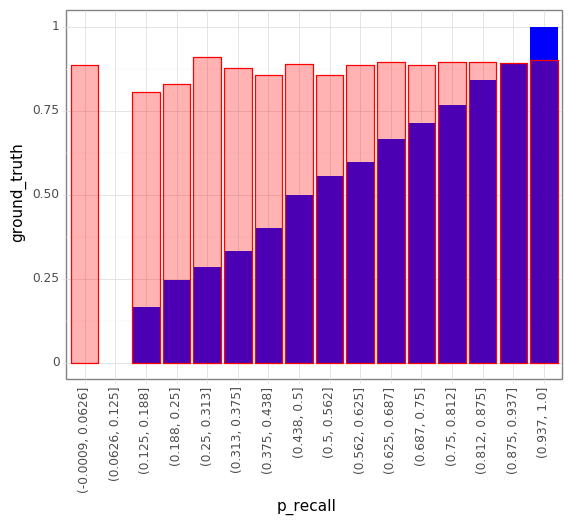

<ggplot: (8775339509025)>

In [82]:
def _bin_miscalibration(group):
    return pd.DataFrame([{
        'miscalibration': (group.pp - group.p_recall).abs().mean(),
        'prediction': group.pp.mean(),
        'ground_truth': group.p_recall.mean()
    }])

miscalibration = results.groupby(
    pd.cut(results.p_recall, 16)).apply(_bin_miscalibration).reset_index()

print('expected calibration error', miscalibration.miscalibration.mean())

(
    ggplot(miscalibration)
    + geom_bar(
        aes(x='p_recall', y='ground_truth'),
        stat='identity',
        fill='blue',
        alpha=1.0
    )
    + geom_bar(
        aes(x='p_recall', y='prediction'),
        stat='identity',
        fill='red',
        color='red',
        alpha=0.3
    )
    + theme_fs()
    + theme(
        axis_text_x=element_text(rotation=90)
    )
)

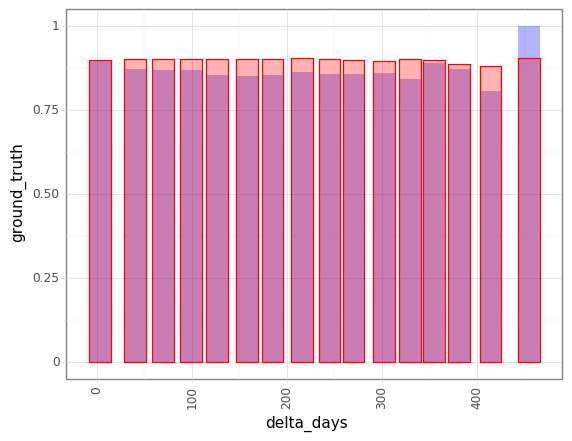

<ggplot: (8775381840797)>

In [83]:
def _bin_delta(group):
    return pd.DataFrame([{
        'prediction': group.pp.mean(),
        'ground_truth': group.p_recall.mean(),
        'delta_days': group.delta.mean(),
    }])

(
    ggplot(
        results.groupby(
            pd.cut(results.delta, 16)
        ).apply(_bin_delta).reset_index()
    )
    + geom_bar(
        aes(x='delta_days', y='ground_truth'),
        stat='identity',
        fill='blue',
        alpha=0.3
    )
    + geom_bar(
        aes(x='delta_days', y='prediction'),
        stat='identity',
        fill='red',
        color='red',
        alpha=0.3
    )
    + theme_fs()
    + theme(
        axis_text_x=element_text(rotation=90)
    )
)

In [84]:
import torch
import torch.nn as nn

In [85]:
from retention import RetentionDataset, Net

In [86]:
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True}
train_dataset = RetentionDataset('train')
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64, shuffle=True, **kwargs)

loading train test numpy


In [87]:
n_input = train_dataset.x.shape[1]
model = Net(n_input=n_input, n_output=1).to(device) 

In [88]:
data, target = next(iter(train_loader))
data, target = data.to(device), target.to(device)

In [89]:
target

tensor([9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01,
        7.5000e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01,
        9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 6.0000e-01,
        9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01,
        9.9990e-01, 9.9990e-01, 9.9990e-01, 1.0000e-04, 9.9990e-01, 9.9990e-01,
        9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01,
        1.0000e-04, 9.9990e-01, 1.0000e-04, 9.9990e-01, 9.9990e-01, 6.6667e-01,
        1.0000e-04, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01, 9.9990e-01,
        5.0000e-01, 9.9990e-01, 9.9990e-01, 1.0000e-04, 9.9990e-01, 8.3333e-01,
        9.9990e-01, 9.9990e-01, 9.9990e-01, 8.0000e-01, 9.9990e-01, 9.9990e-01,
        9.9990e-01, 9.9990e-01, 1.0000e-04, 9.9990e-01], device='cuda:0')

In [90]:
torch.log(target)

tensor([-1.0002e-04, -1.0002e-04, -1.0002e-04, -1.0002e-04, -1.0002e-04,
        -1.0002e-04, -2.8768e-01, -1.0002e-04, -1.0002e-04, -1.0002e-04,
        -1.0002e-04, -1.0002e-04, -1.0002e-04, -1.0002e-04, -1.0002e-04,
        -1.0002e-04, -1.0002e-04, -5.1083e-01, -1.0002e-04, -1.0002e-04,
        -1.0002e-04, -1.0002e-04, -1.0002e-04, -1.0002e-04, -1.0002e-04,
        -1.0002e-04, -1.0002e-04, -9.2103e+00, -1.0002e-04, -1.0002e-04,
        -1.0002e-04, -1.0002e-04, -1.0002e-04, -1.0002e-04, -1.0002e-04,
        -1.0002e-04, -9.2103e+00, -1.0002e-04, -9.2103e+00, -1.0002e-04,
        -1.0002e-04, -4.0547e-01, -9.2103e+00, -1.0002e-04, -1.0002e-04,
        -1.0002e-04, -1.0002e-04, -1.0002e-04, -6.9315e-01, -1.0002e-04,
        -1.0002e-04, -9.2103e+00, -1.0002e-04, -1.8232e-01, -1.0002e-04,
        -1.0002e-04, -1.0002e-04, -2.2314e-01, -1.0002e-04, -1.0002e-04,
        -1.0002e-04, -1.0002e-04, -9.2103e+00, -1.0002e-04], device='cuda:0')